In [1]:
import os, json, numpy as np, torch
from tqdm import tqdm

vocab_path = '../data/flickr_vocab.json'
encoded_caps_path = '../data/flickr_encoded_captions.json'
train_images_json = '../data/flickr_train_images.json'
test_images_json = '../data/flickr_test_images.json'

with open(vocab_path, 'r') as f:
    vocab_data = json.load(f)
word2idx = vocab_data['word2idx']
idx2word = {int(k):v for k,v in vocab_data['idx2word'].items()}  

with open(encoded_caps_path, 'r') as f:
    encoded_captions = json.load(f)  

with open(train_images_json, 'r') as f:
    train_image_list = json.load(f)
with open(test_images_json, 'r') as f:
    test_image_list = json.load(f)

vocab_size = len(word2idx)
pad_idx = word2idx['<pad>']
start_idx = word2idx['<start>']
end_idx = word2idx['<end>']

print("Vocab size:", vocab_size)
print("Train images:", len(train_image_list), "Test images:", len(test_image_list))
max_len = len(next(iter(next(iter(encoded_captions.values())))))
print("Detected max_len:", max_len)

spatial_dir = '../features_spatial'  
os.makedirs(spatial_dir, exist_ok=True)


Vocab size: 2995
Train images: 6000 Test images: 1000
Detected max_len: 20


In [2]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()

resnet = resnet50(weights=weights).to(device).eval()

layer4_feats = {}
def hook_fn(module, input, output):
    layer4_feats['feat'] = output.detach().cpu()

resnet.layer4.register_forward_hook(hook_fn)

all_images = sorted(list(set(train_image_list + test_image_list)))
image_dir = '../data/Flickr8k_Dataset/Flicker8k_Dataset'  

for img_name in tqdm(all_images, desc='Extracting spatial features'):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        _ = resnet(img_t)  
        feat4 = layer4_feats['feat'].squeeze(0) 
        C, H, W = feat4.shape
        spatial = feat4.view(C, -1).permute(1,0).numpy()  
        save_path = os.path.join(spatial_dir, img_name.replace('.jpg','_spatial.npy'))
        np.save(save_path, spatial)
print("Saved spatial features to", spatial_dir)


Extracting spatial features: 100%|█████████████████████████████████████████████████| 7000/7000 [17:16<00:00,  6.76it/s]

Saved spatial features to ../features_spatial


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import random

class FlickrEncodedDataset(Dataset):
    def __init__(self, image_list, encoded_captions, spatial_dir, max_len):
        self.image_list = image_list
        self.encoded_captions = encoded_captions
        self.spatial_dir = spatial_dir
        self.max_len = max_len

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        enc_list = self.encoded_captions[img_name]
        enc = random.choice(enc_list)
        caption_tensor = torch.tensor(enc, dtype=torch.long)
        spatial = np.load(os.path.join(self.spatial_dir, img_name.replace('.jpg','_spatial.npy')))  
        spatial = torch.tensor(spatial, dtype=torch.float32)
        return spatial, caption_tensor, img_name

def collate_fn(batch):
    spatials = torch.stack([b[0] for b in batch], dim=0)  
    caps = torch.stack([b[1] for b in batch], dim=0)      
    img_names = [b[2] for b in batch]
    return spatials, caps, img_names

batch_size = 32
train_dataset = FlickrEncodedDataset(train_image_list, encoded_captions, spatial_dir, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)                       
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)       
        scores = self.full_att(torch.tanh(att1 + att2)).squeeze(2)
        alpha = F.softmax(scores, dim=1)                           
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)    
        return context, alpha

class DecoderWithAttention(nn.Module):
    def __init__(self, encoder_dim, attention_dim, embed_dim, decoder_dim, vocab_size, pad_idx, dropout=0.5):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.dropout = nn.Dropout(p=dropout)

    def init_hidden_state(self, encoder_out):
        mean = encoder_out.mean(dim=1)   
        h = self.init_h(mean)
        c = self.init_c(mean)
        return h, c

    def forward(self, encoder_out, captions, teacher_forcing_ratio=1.0):
        device = encoder_out.device
        batch_size = encoder_out.size(0)
        max_len = captions.size(1) - 1 
        vocab_size = self.fc.out_features

        embeddings = self.embedding(captions)  
        h, c = self.init_hidden_state(encoder_out)
        preds = torch.zeros(batch_size, max_len, vocab_size, device=device)
        alphas = torch.zeros(batch_size, max_len, encoder_out.size(1), device=device)

        prev_word = embeddings[:, 0, :]  
        for t in range(max_len):
            context, alpha = self.attention(encoder_out, h) 
            gate = self.sigmoid(self.f_beta(h))
            context = gate * context
            lstm_in = torch.cat([prev_word, context], dim=1)
            h, c = self.decode_step(lstm_in, (h, c))
            output = self.fc(self.dropout(h)) 
            preds[:, t, :] = output
            alphas[:, t, :] = alpha
            if torch.rand(1).item() < teacher_forcing_ratio:
                prev_word = embeddings[:, t+1, :]
            else:
                top1 = output.argmax(1)
                prev_word = self.embedding(top1)
        return preds, alphas


In [5]:
sample = train_dataset[0]
print(len(sample))
print(type(sample))
print(sample)


3
<class 'tuple'>
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([  12, 2807,  752, 2154, 2682,   13, 1505, 1511,  285, 1702, 2892,   11,
           0,    0,    0,    0,    0,    0,    0,    0]), '2513260012_03d33305cf.jpg')


In [6]:
import torch.optim as optim
from tqdm import tqdm

encoder_dim = None
sample_spatial = np.load(os.path.join(spatial_dir, train_image_list[0].replace('.jpg','_spatial.npy')))
encoder_dim = sample_spatial.shape[1]
print("Detected encoder_dim:", encoder_dim)

attention_dim = 512
embed_dim = 512
decoder_dim = 512
vocab_size = vocab_size
pad_idx = pad_idx

decoder = DecoderWithAttention(encoder_dim, attention_dim, embed_dim, decoder_dim, vocab_size, pad_idx).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=1e-5)

num_epochs = 15
for epoch in range(num_epochs):
    decoder.train()
    total_loss = 0.0
    for encoder_out, captions, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        encoder_out = encoder_out.to(device)  
        captions = captions.to(device)        
        optimizer.zero_grad()
        outputs, alphas = decoder(encoder_out, captions, teacher_forcing_ratio=0.8)
        targets = captions[:,1:] 
        B, T, V = outputs.shape
        loss = criterion(outputs.reshape(-1, V), targets.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")


Detected encoder_dim: 2048


Epoch 1/15: 100%|████████████████████████████████████████████████████████████████████| 188/188 [06:10<00:00,  1.97s/it]


Epoch 1 Avg Loss: 5.5970


Epoch 2/15: 100%|████████████████████████████████████████████████████████████████████| 188/188 [05:46<00:00,  1.84s/it]


Epoch 2 Avg Loss: 4.6963


Epoch 3/15: 100%|████████████████████████████████████████████████████████████████████| 188/188 [05:43<00:00,  1.83s/it]


Epoch 3 Avg Loss: 4.4752


Epoch 4/15: 100%|████████████████████████████████████████████████████████████████████| 188/188 [05:48<00:00,  1.85s/it]


Epoch 4 Avg Loss: 4.2951


Epoch 5/15: 100%|████████████████████████████████████████████████████████████████████| 188/188 [05:43<00:00,  1.83s/it]


Epoch 5 Avg Loss: 4.1840


Epoch 6/15: 100%|████████████████████████████████████████████████████████████████████| 188/188 [05:57<00:00,  1.90s/it]


Epoch 6 Avg Loss: 4.0802


Epoch 7/15: 100%|████████████████████████████████████████████████████████████████████| 188/188 [06:01<00:00,  1.92s/it]


Epoch 7 Avg Loss: 3.9914


Epoch 8/15: 100%|████████████████████████████████████████████████████████████████████| 188/188 [06:05<00:00,  1.94s/it]


Epoch 8 Avg Loss: 3.8881


Epoch 9/15: 100%|████████████████████████████████████████████████████████████████████| 188/188 [05:57<00:00,  1.90s/it]


Epoch 9 Avg Loss: 3.8421


Epoch 10/15: 100%|███████████████████████████████████████████████████████████████████| 188/188 [05:51<00:00,  1.87s/it]


Epoch 10 Avg Loss: 3.7796


Epoch 11/15: 100%|███████████████████████████████████████████████████████████████████| 188/188 [06:16<00:00,  2.00s/it]


Epoch 11 Avg Loss: 3.7537


Epoch 12/15: 100%|███████████████████████████████████████████████████████████████████| 188/188 [05:52<00:00,  1.88s/it]


Epoch 12 Avg Loss: 3.6763


Epoch 13/15: 100%|███████████████████████████████████████████████████████████████████| 188/188 [05:45<00:00,  1.84s/it]


Epoch 13 Avg Loss: 3.6162


Epoch 14/15: 100%|███████████████████████████████████████████████████████████████████| 188/188 [05:45<00:00,  1.84s/it]


Epoch 14 Avg Loss: 3.5712


Epoch 15/15: 100%|███████████████████████████████████████████████████████████████████| 188/188 [05:44<00:00,  1.83s/it]

Epoch 15 Avg Loss: 3.5476


In [18]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm

model_predictions = {}
refs = []
hyps = []

decoder.eval()
eval_list = test_image_list 
print("Generating captions and evaluating on test set...")

for img_name in tqdm(eval_list, desc='Processing test images'):
    spatial = torch.tensor(
        np.load(os.path.join(spatial_dir, img_name.replace('.jpg', '_spatial.npy'))),
        dtype=torch.float32
    ).to(device)

    gen_words, _ = decode_greedy(decoder, spatial, idx2word, word2idx, max_len)
    model_predictions[img_name] = ' '.join(gen_words)
    hyps.append(gen_words)

    ref_encs = encoded_captions[img_name]
    ref_tokens = []
    for enc in ref_encs:
        words = []
        for idx in enc:
            if str(idx) in idx2word:
                w = idx2word[str(idx)]
            else:
                w = idx2word.get(idx, '<unk>')
            if w in ['<start>', '<end>', '<pad>']:
                continue
            words.append(w)
        ref_tokens.append(words)
    refs.append(ref_tokens)

Generating captions and evaluating on test set...


In [13]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
nltk.download('punkt')
nltk.download('wordnet')

def decode_greedy(decoder, encoder_out, idx2word, word2idx, max_len):
    decoder.eval()
    device = encoder_out.device
    with torch.no_grad():
        encoder_out = encoder_out.unsqueeze(0) if encoder_out.dim()==2 else encoder_out
        h, c = decoder.init_hidden_state(encoder_out)
        prev = torch.tensor([word2idx['<start>']], device=device)
        prev_embed = decoder.embedding(prev) 
        generated = []
        alphas = []
        for _ in range(max_len-1):
            context, alpha = decoder.attention(encoder_out, h)
            gate = decoder.sigmoid(decoder.f_beta(h))
            context = gate * context
            inp = torch.cat([prev_embed, context], dim=1)
            h, c = decoder.decode_step(inp, (h, c))
            out = decoder.fc(h) 
            top1 = out.argmax(1).item()
            if top1 == word2idx['<end>']:
                break
            generated.append(idx2word[str(top1)] if isinstance(next(iter(idx2word)), str) else idx2word[top1])
            alphas.append(alpha.cpu().numpy().flatten())
            prev = torch.tensor([top1], device=device)
            prev_embed = decoder.embedding(prev)
    return generated, np.array(alphas)

refs = []
hyps = []
decoder.eval()

eval_list = test_image_list  
for img_name in tqdm(eval_list, desc='Generating captions for BLEU & METEOR'):
    spatial = torch.tensor(np.load(os.path.join(spatial_dir, img_name.replace('.jpg','_spatial.npy'))), dtype=torch.float32).to(device)
    gen_words, _ = decode_greedy(decoder, spatial, idx2word, word2idx, max_len)
    hyps.append(gen_words)
    
    ref_encs = encoded_captions[img_name]  
    ref_tokens = []
    for enc in ref_encs:
        words = []
        for idx in enc:
            if str(idx) in idx2word:
                w = idx2word[str(idx)]
            else:
                w = idx2word.get(idx, '<unk>')
            if w in ['<start>','<end>','<pad>']:
                continue
            words.append(w)
        ref_tokens.append(words)
    refs.append(ref_tokens)

bleu1 = corpus_bleu(refs, hyps, weights=(1, 0, 0, 0))
bleu2 = corpus_bleu(refs, hyps, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(refs, hyps, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(refs, hyps, weights=(0.25, 0.25, 0.25, 0.25))
avg_bleu = (bleu1 + bleu2 + bleu3 + bleu4) / 4

meteor_scores = []
for ref_list, hyp in zip(refs, hyps):
    try:
        meteor_scores.append(meteor_score(ref_list, hyp))
    except Exception as e:
        print(f"Error computing METEOR for {hyp}: {e}")

avg_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0.0

print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")
print(f"Avg BLEU (1-4): {avg_bleu:.4f}")
print(f"METEOR: {avg_meteor:.4f}")

[nltk_data] Downloading package punkt to
[nltk_data]     <local_path>
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     <local_path>
[nltk_data]   Package wordnet is already up-to-date!
Generating captions for BLEU & METEOR: 100%|███████████████████████████████████████| 1000/1000 [00:47<00:00, 21.20it/s]


BLEU-1: 0.6168
BLEU-2: 0.4231
BLEU-3: 0.2750
BLEU-4: 0.1714
Avg BLEU (1-4): 0.3716
METEOR: 0.3795


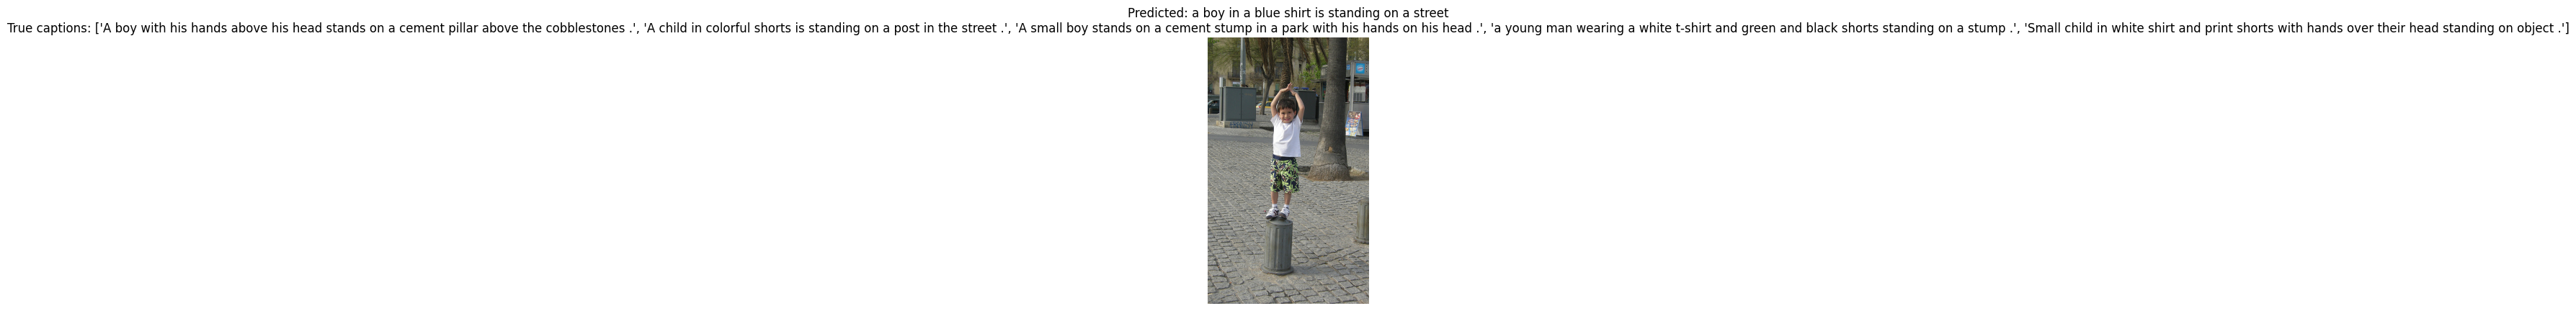

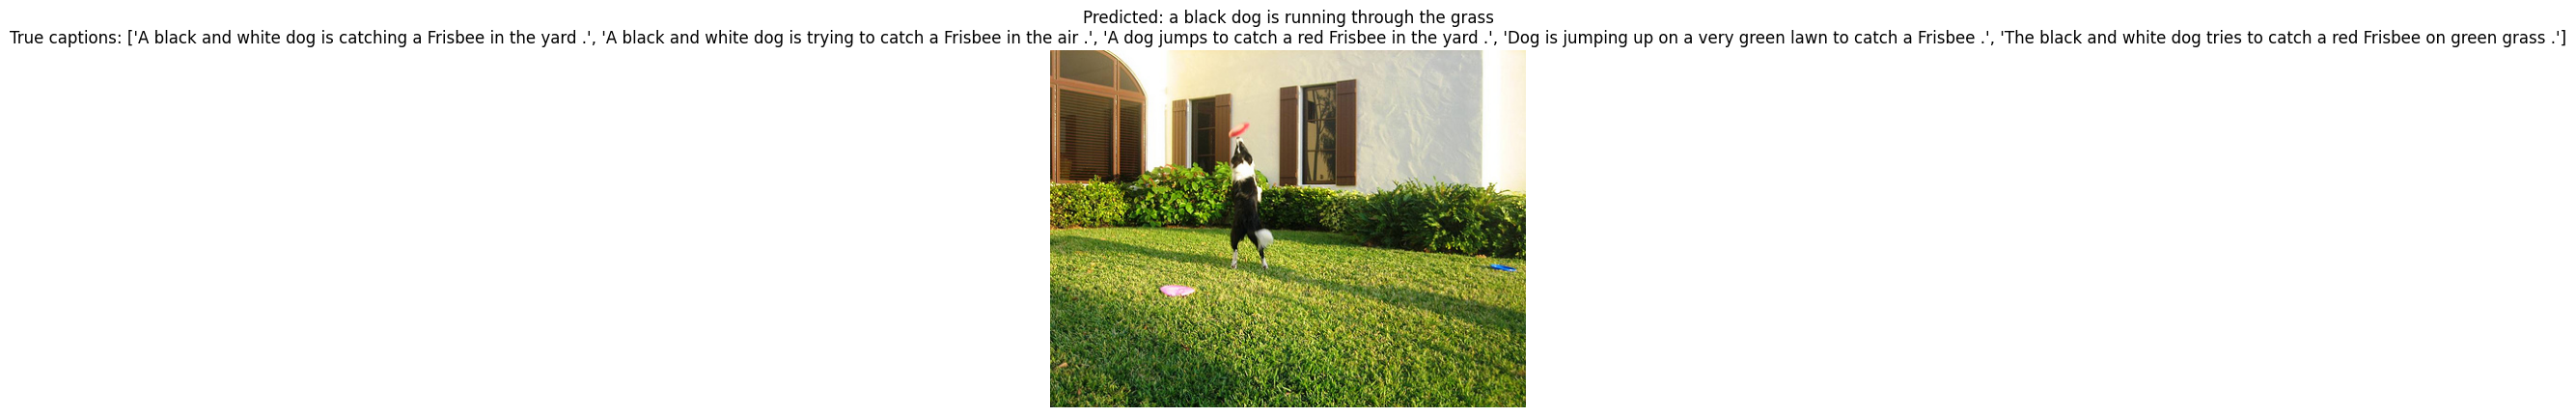

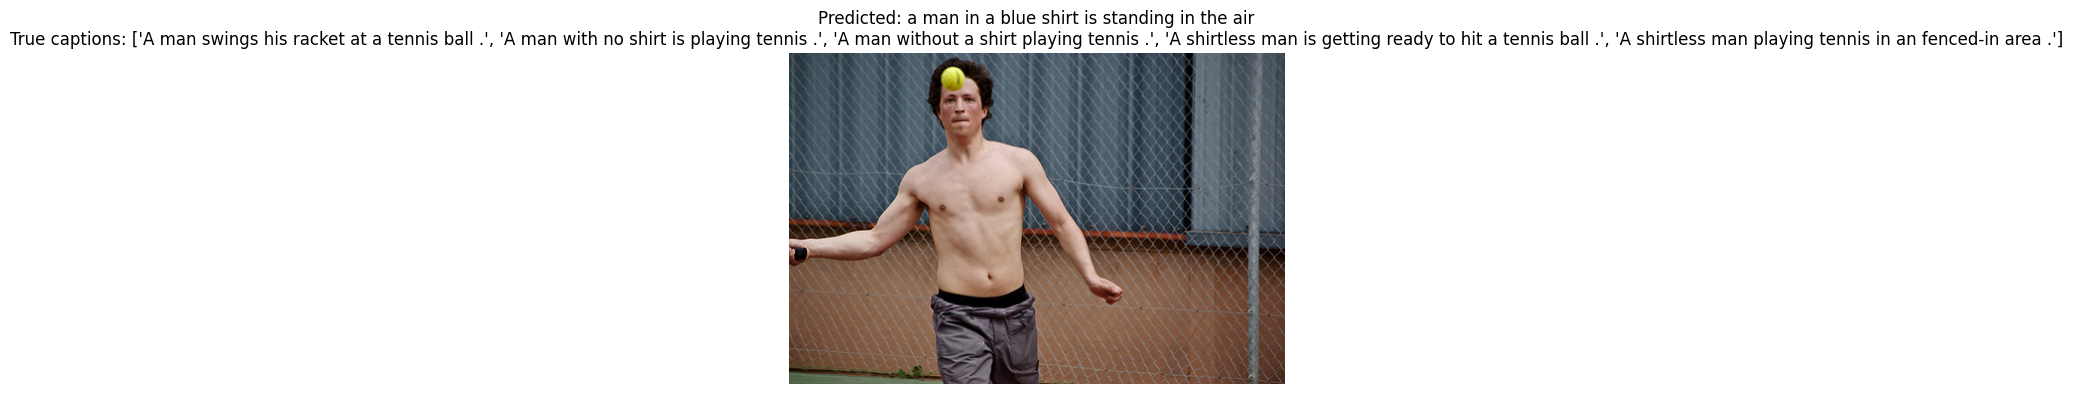

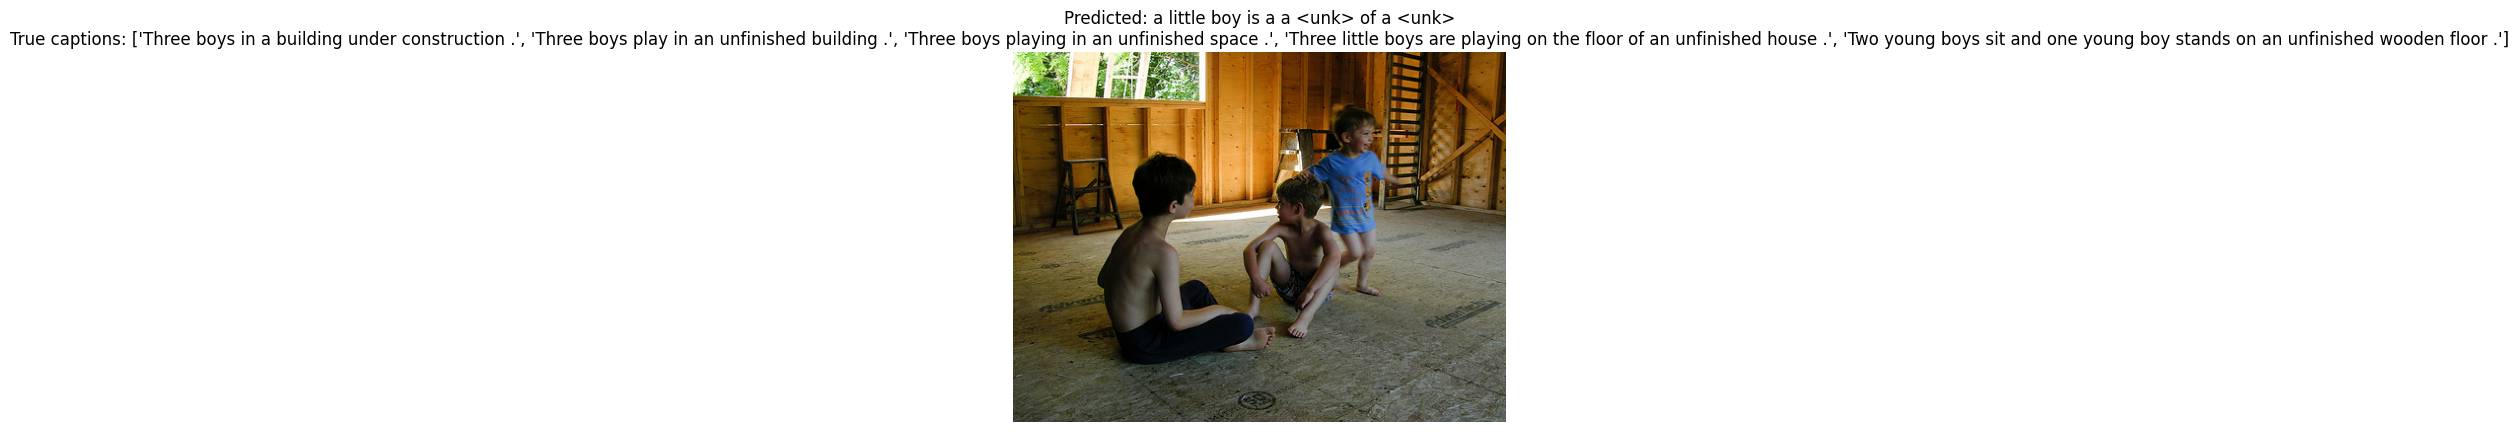

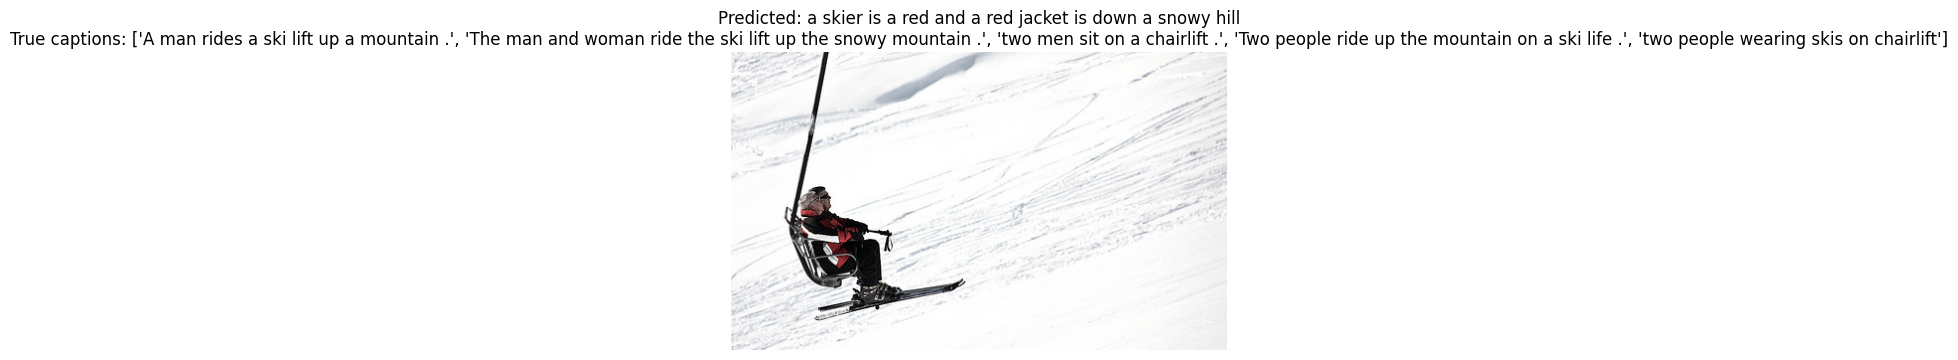

In [21]:
def load_captions(file_path):
    captions_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            img, caption = line.strip().split('\t')
            img_id = img.split('#')[0]
            captions_dict.setdefault(img_id, []).append(caption)
    return captions_dict

true_captions_dict = load_captions(os.path.join(flickr8k_text_dir, "Flickr8k.token.txt"))

sample_imgs = random.sample(test_image_list, 5)

for img_name in sample_imgs:
    img_path = os.path.join(image_dir, img_name)
    image = Image.open(img_path)

    plt.imshow(image)
    plt.axis('off')
    plt.title(
        f"Predicted: {model_predictions[img_name]}\n"
        f"True captions: {true_captions_dict[img_name]}"
    )
    plt.show()


In [31]:
def decode_beam_search(decoder, encoder_out, idx2word, word2idx, max_len, beam_size=3):
    decoder.eval()
    device = encoder_out.device
    with torch.no_grad():
        encoder_out = encoder_out.unsqueeze(0) if encoder_out.dim()==2 else encoder_out
        k = beam_size
        num_pixels = encoder_out.size(1)
        h, c = decoder.init_hidden_state(encoder_out)

        prev_word = torch.LongTensor([[word2idx['<start>']]] * k).to(device)
        sequences = prev_word  
        seq_scores = torch.zeros(k, 1).to(device)
        complete_seqs = []
        complete_scores = []

        encoder_out = encoder_out.expand(k, num_pixels, encoder_out.size(2))
        h = h.expand(k, h.size(1))
        c = c.expand(k, c.size(1))

        for _ in range(max_len - 1):
            prev_embed = decoder.embedding(sequences[:, -1])
            context, _ = decoder.attention(encoder_out, h)
            gate = decoder.sigmoid(decoder.f_beta(h))
            context = gate * context
            inp = torch.cat([prev_embed, context], dim=1)
            h, c = decoder.decode_step(inp, (h, c))
            out = decoder.fc(h)  
            log_probs = torch.log_softmax(out, dim=1)

            scores = seq_scores + log_probs
            topk_scores, topk_words = scores.view(-1).topk(k, 0, True, True)

            prev_seq_inds = topk_words // len(idx2word) if isinstance(next(iter(idx2word)), str) else topk_words // len(idx2word)
            next_words = topk_words % len(idx2word)

            sequences = torch.cat([sequences[prev_seq_inds], next_words.unsqueeze(1)], dim=1)
            seq_scores = topk_scores.unsqueeze(1)

            incomplete_inds = []
            for i, word in enumerate(next_words):
                if word.item() == word2idx['<end>']:
                    complete_seqs.append(sequences[i].tolist())
                    complete_scores.append(seq_scores[i])
                else:
                    incomplete_inds.append(i)

            if len(incomplete_inds) == 0:
                break

            sequences = sequences[incomplete_inds]
            h = h[prev_seq_inds[incomplete_inds]]
            c = c[prev_seq_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_seq_inds[incomplete_inds]]
            seq_scores = seq_scores[incomplete_inds]

        if len(complete_scores) > 0:
            best_seq = complete_seqs[complete_scores.index(max(complete_scores))]
        else:
            best_seq = sequences[0].tolist()

        generated = [
            idx2word[str(idx)] if isinstance(next(iter(idx2word)), str) else idx2word[idx]
            for idx in best_seq
            if idx not in (word2idx['<start>'], word2idx['<end>'], word2idx['<pad>'])
        ]
    return generated, None  

In [32]:
model_predictions = {}
refs = []
hyps = []

eval_list = test_image_list
print("Generating captions using Beam Search and evaluating on test set...")

for img_name in tqdm(eval_list, desc='Beam Search on test set'):
    spatial = torch.tensor(
        np.load(os.path.join(spatial_dir, img_name.replace('.jpg', '_spatial.npy'))),
        dtype=torch.float32
    ).to(device)

    gen_words, _ = decode_beam_search(decoder, spatial, idx2word, word2idx, max_len, beam_size=3)
    model_predictions[img_name] = ' '.join(gen_words)
    hyps.append(gen_words)

    ref_encs = encoded_captions[img_name]
    ref_tokens = []
    for enc in ref_encs:
        words = []
        for idx in enc:
            if str(idx) in idx2word:
                w = idx2word[str(idx)]
            else:
                w = idx2word.get(idx, '<unk>')
            if w in ['<start>', '<end>', '<pad>']:
                continue
            words.append(w)
        ref_tokens.append(words)
    refs.append(ref_tokens)

bleu1 = corpus_bleu(refs, hyps, weights=(1, 0, 0, 0))
bleu2 = corpus_bleu(refs, hyps, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(refs, hyps, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(refs, hyps, weights=(0.25, 0.25, 0.25, 0.25))
avg_bleu = (bleu1 + bleu2 + bleu3 + bleu4) / 4

meteor_scores = []
for ref_list, hyp in zip(refs, hyps):
    try:
        meteor_scores.append(meteor_score(ref_list, hyp))
    except Exception as e:
        print(f"Error computing METEOR for {hyp}: {e}")

avg_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0.0

print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")
print(f"Avg BLEU (1-4): {avg_bleu:.4f}")
print(f"METEOR: {avg_meteor:.4f}")

Generating captions using Beam Search and evaluating on test set...


Beam Search on test set: 100%|█████████████████████████████████████████████████████| 1000/1000 [01:21<00:00, 12.24it/s]


BLEU-1: 0.6168
BLEU-2: 0.4231
BLEU-3: 0.2750
BLEU-4: 0.1714
Avg BLEU (1-4): 0.3716
METEOR: 0.3795


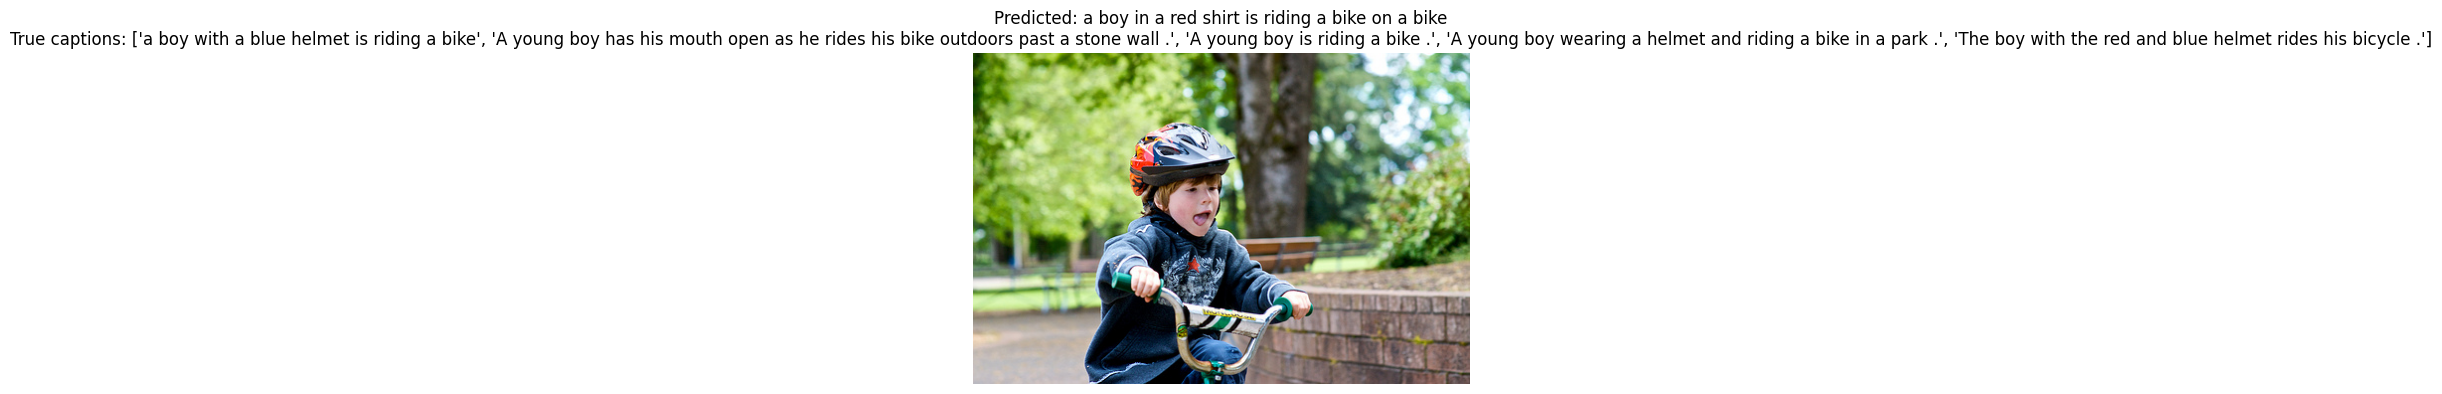

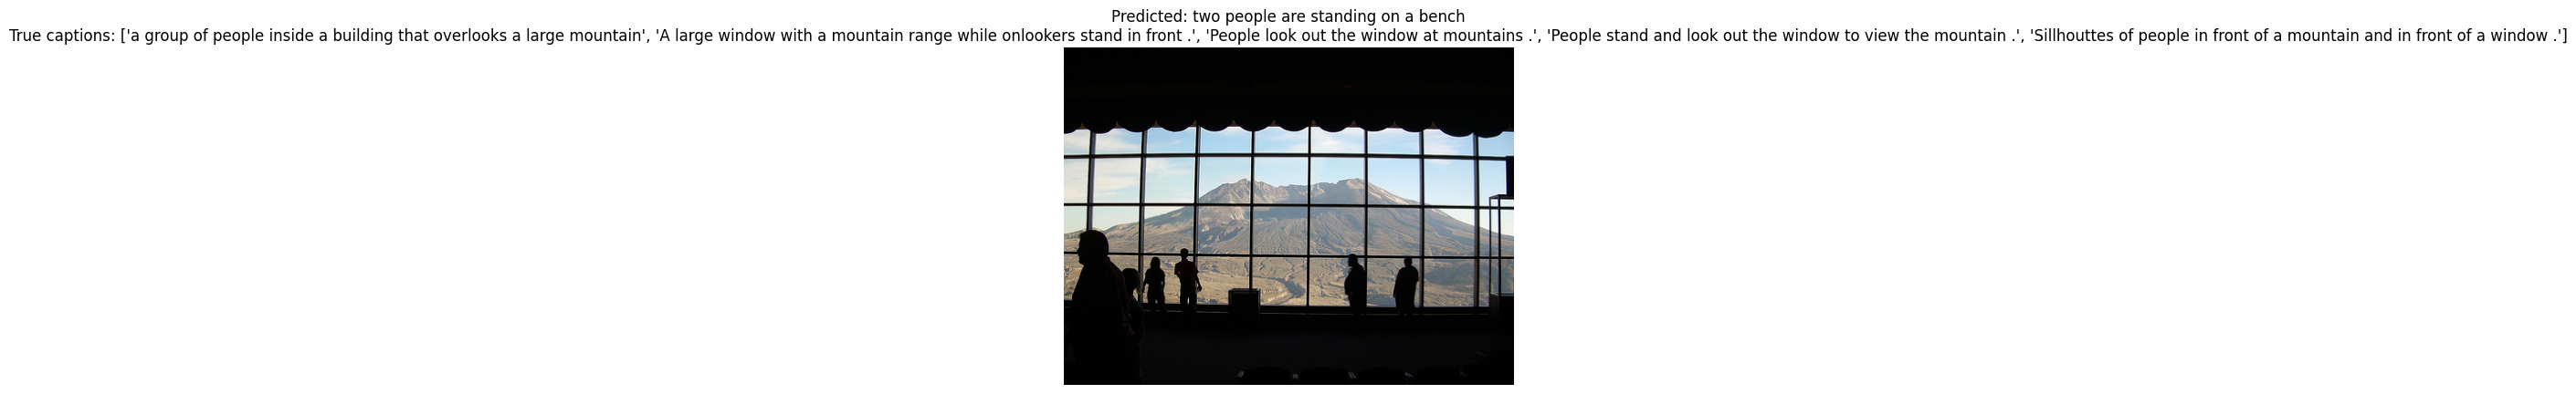

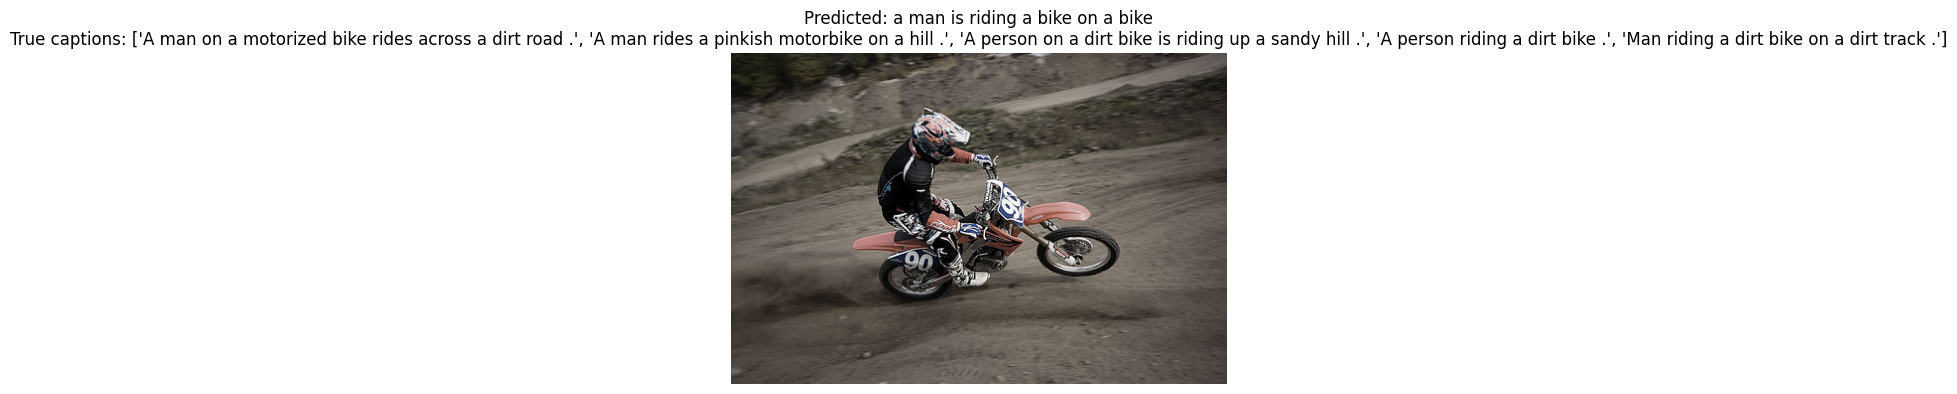

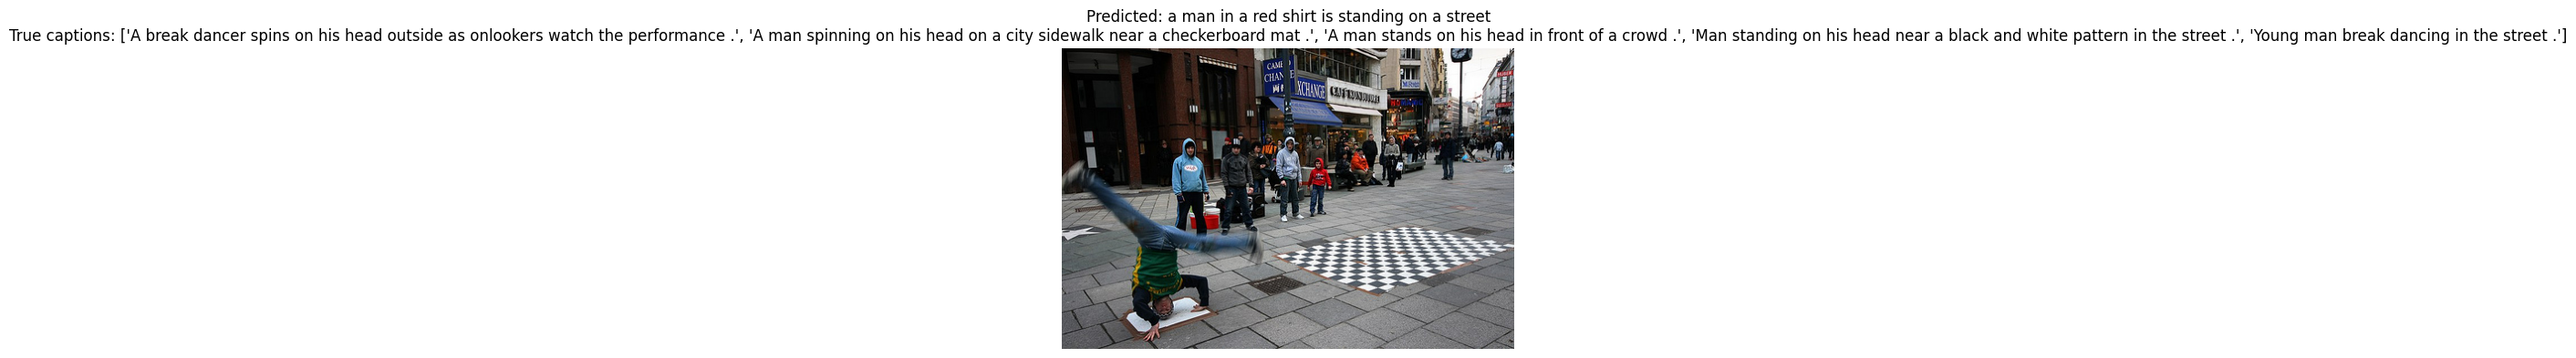

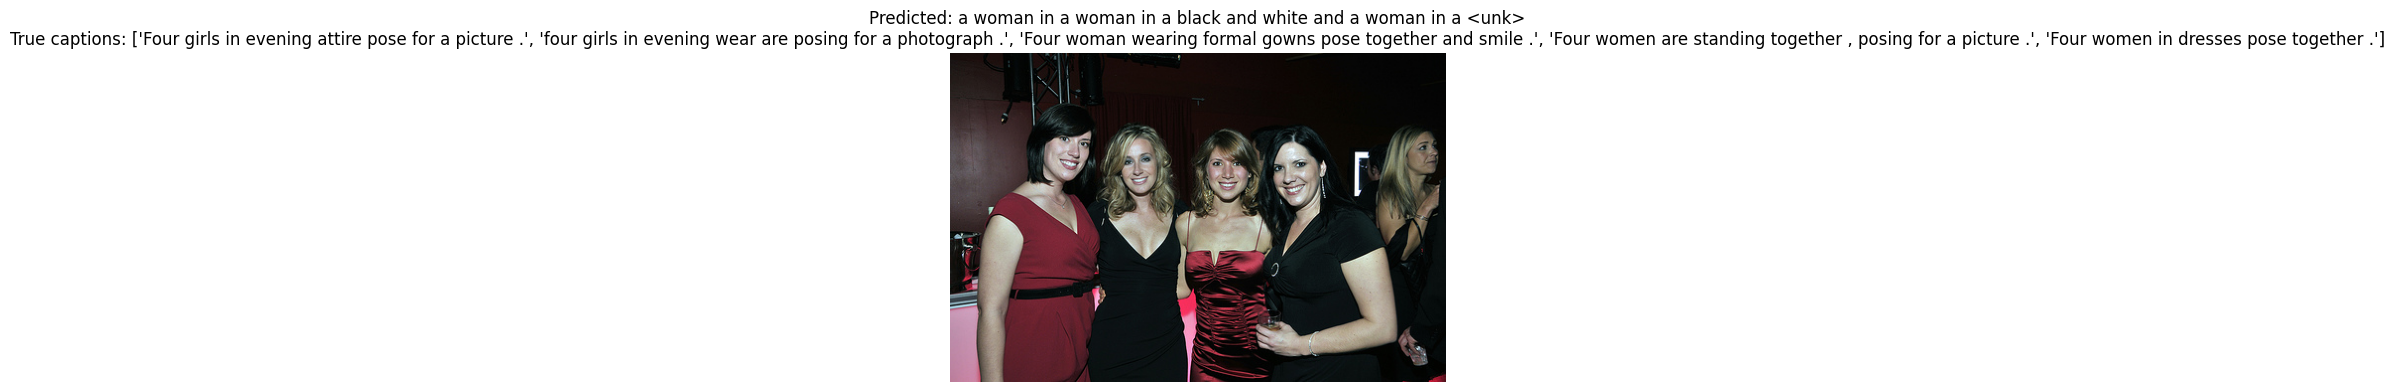

In [33]:
def load_captions(file_path):
    captions_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            img, caption = line.strip().split('\t')
            img_id = img.split('#')[0]
            captions_dict.setdefault(img_id, []).append(caption)
    return captions_dict

true_captions_dict = load_captions(os.path.join(flickr8k_text_dir, "Flickr8k.token.txt"))
sample_imgs = random.sample(test_image_list, 5)

for img_name in sample_imgs:
    img_path = os.path.join(image_dir, img_name)
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(
        f"Predicted: {model_predictions[img_name]}\n"
        f"True captions: {true_captions_dict[img_name]}"
    )
    plt.show()